In [1]:
import os
os.chdir('../quafing/')

import random
import pickle
import numpy as np
import scipy.stats
import quafing as q
from collections import Counter

import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

from alive_progress import alive_it, config_handler
config_handler.set_global(bar="notes", force_tty=True)

from astropy.stats import histogram, bayesian_blocks

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

In [2]:
def load_data(path):
    """
    Loads .dta file using provided path.
    """
    return pd.read_stata(path, convert_categoricals=False)



def get_processed_df(results):
    processed = pd.DataFrame.from_dict({})
    for column in results[1]:
        processed[column] = [results[hhid][column] for hhid in results]
    return processed

In [3]:
DATA_DIR    = "../../BCCASII/"
DATA_SUBDIR = "Household/"

In [4]:
filename = "001_mod_a.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)
UNIQUE_HHID = np.round(df["hhid"].unique().astype(np.float64), 1)

# Income

In [5]:
filename = "032_mod_t.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [6]:
results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    monthly_incomes = [x for x in household["t14"] if not np.isnan(x)]
    results[hhid]["income"] = sum(monthly_incomes) if len(monthly_incomes) else np.nan      
income = get_processed_df(results)

In [7]:
vals = np.array([x for x in income["income"] if not np.isnan(x)])
edges = bayesian_blocks(vals, fitness='events', p0=1e-20)
incomes = {}
for index, row in income.iterrows():
    hhid = row["hhid"]
    val  = row["income"]
    incomes[hhid] = val if not np.isnan(val) else None

# Prediction

In [8]:
def get_occupations(survey):
    if survey == 1:
        filename = "003_mod_b.dta"
        path = "../../BCCASI/" + DATA_SUBDIR + filename
        cols = ["b08_1", "b08_2"]
    else:
        filename = "002_mod_b.dta"
        path = DATA_DIR + DATA_SUBDIR + filename
        cols = ["b08_1", "b08_2", "b08_3"]
        
    cols = ["b08_1"]
        
    df = load_data(path)

    job_categories = {
        0: [1,2,3],
        1: [4,5,6,7,8],
        2: [9],
        3: [10,11,12,13],
        4: [14,15],
        5: [16,17,18],
        6: [19],
    }

    job_categories_inv = {}
    for category, vals in job_categories.items():
        for v in vals:
            job_categories_inv[v] = category

    occupations = {}
    for hhid in UNIQUE_HHID:
        household = df.loc[df.hhid==hhid]
        jobs = []
        for col in cols:
            items = set(household[col])
            items = [x for x in items if not np.isnan(x) and x!=99 and x <= 19]
            jobs += items
        occupations[hhid] = [job_categories_inv[x] for x in jobs]
        
    return occupations

In [9]:
O1 = get_occupations(1)

In [10]:
O2 = get_occupations(2)

In [106]:
errors = []

lengths = np.linspace(30, 800, 15, dtype=int)

for train_len in lengths:

    train_keys = list(O2.keys())[:train_len]
    test_keys  = list(O2.keys())[train_len:]
    test_preds = []

    for k in test_keys:
        target = sorted(O2[k])
        pred = []
        for kk in train_keys:
            if target == sorted(O2[kk]):
                amount = incomes[kk]
                if amount is None:
                    continue
                else:
                    pred.append(amount)
        if len(pred):   
            test_preds.append(np.mean(pred))
        else:
            test_preds.append(-1)

    # error is norm of difference
    indices = []
    for i in range(len(test_preds)):
        if incomes[test_keys[i]] is not None and test_preds[i] != -1:
            indices.append(i)
    error = np.linalg.norm(np.array(test_preds)[indices] - np.array([incomes[x] for x in test_keys])[indices])
    errors.append(error)

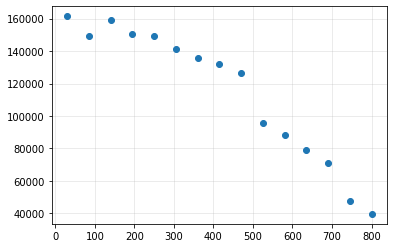

In [107]:
plt.scatter(lengths, errors)
plt.show()

In [108]:
np.array(test_preds)[indices]

array([ 6181.67121677,  7040.29487179,  8234.20056613,  8234.20056613,
        8234.20056613,  8234.20056613,  7040.29487179,  6181.67121677,
        7040.29487179, 11126.625     ,  6181.67121677,  6181.67121677,
        6181.67121677,  6181.67121677,  7040.29487179,  9121.92031211,
        1506.56363636,  6181.67121677,  8234.20056613,  6181.67121677,
        8234.20056613,  7040.29487179,  6181.67121677,  8234.20056613,
        6181.67121677,  6181.67121677,  1506.56363636])

In [109]:
np.array([incomes[x] for x in test_keys])[indices]

array([ 3133., 35000.,  8000.,  5916., 12530.,  9842., 17700.,  1393.,
        8040.,  6050.,  9666.,  7916., 20000.,  5300.,  6550., 12246.,
           0., 13400.,  7140.,   816.,  3225.,  3625., 20563.,  4800.,
        3530.,  1200.,  1000.])

In [111]:
# predict on survey 1
for hhid, job_list in O1.items():
    print(hhid)
    target = sorted(job_list)
    pred = []
    for k, vals in O2.items():
        if target == sorted(vals):
            amount = incomes[k]
            if amount is None:
                continue
            else:
                pred.append(amount)
                
    print(np.mean(pred))
    print()

1.0
6236.03505761596

2.0
8131.093833414713

3.0
5650.0

4.0
6236.03505761596

5.0
13335.0

6.0
6236.03505761596

7.0
7470.578313253012

8.0
6236.03505761596

9.0
8131.093833414713

10.0
6236.03505761596

11.0
6236.03505761596

12.0
8131.093833414713

13.0
6236.03505761596

14.0
7470.578313253012

15.0
6236.03505761596

16.0
6615.75

17.0
6236.03505761596

18.0
8131.093833414713

19.0
6236.03505761596

20.0
6236.03505761596

21.0
7139.387096774193

22.0
6236.03505761596

23.0
8131.093833414713

24.0
6236.03505761596

25.0
6236.03505761596

26.0
6236.03505761596

27.0
6236.03505761596

28.0
6236.03505761596

29.0
6236.03505761596

30.0
6236.03505761596

31.0
6236.03505761596

32.0
8131.093833414713

33.0
6236.03505761596

34.0
6236.03505761596

35.0
7470.578313253012

36.0
10941.5

37.0
6236.03505761596

38.0
6236.03505761596

39.0
6236.03505761596

40.0
10941.5

41.0
6236.03505761596

42.0
6236.03505761596

43.0
6236.03505761596

44.0
6236.03505761596

45.0
6236.03505761596

46.0
1471.

6236.03505761596

352.0
1471.2456140350878

353.0
7470.578313253012

354.0
9169.983076535738

355.0
7470.578313253012

356.0
9169.983076535738

357.0
6236.03505761596

358.0
6236.03505761596

359.0
8131.093833414713

360.0
6236.03505761596

361.0
1471.2456140350878

362.0
10550.0

363.0
8131.093833414713

364.0
7470.578313253012

365.0
6236.03505761596

366.0
10575.0

367.0
6236.03505761596

368.0
8131.093833414713

369.1
1471.2456140350878

369.2
1471.2456140350878

369.3
1471.2456140350878

370.0
7470.578313253012

371.0
6236.03505761596

372.0
6236.03505761596

373.0
7470.578313253012

374.0
6236.03505761596

375.0
9169.983076535738

376.0
9169.983076535738

377.0
6236.03505761596

378.0
7470.578313253012

379.0
1471.2456140350878

380.0
9169.983076535738

381.0
6236.03505761596

382.0
6236.03505761596

383.0
6236.03505761596

384.0
10538.042857033866

385.1
1471.2456140350878

385.2
1471.2456140350878

386.0
6236.03505761596

387.0
6236.03505761596

388.0
6236.03505761596

389.0
62

714.1
1471.2456140350878

714.2
1471.2456140350878

715.0
6236.03505761596

716.0
6236.03505761596

717.0
9501.375

718.0
6236.03505761596

719.0
6236.03505761596

720.0
6236.03505761596

721.0
9501.375

722.0
6236.03505761596

723.0
6236.03505761596

724.0
6236.03505761596

725.0
6236.03505761596

726.0
6236.03505761596

727.0
6236.03505761596

728.0
7470.578313253012

729.0
9169.983076535738

730.0
6236.03505761596

731.0
10562.555555555555

732.0
6236.03505761596

733.0
6236.03505761596

734.0
9501.375

735.0
6236.03505761596

736.0
6236.03505761596

737.0
6236.03505761596

738.0
6236.03505761596

739.0
6236.03505761596

740.0
6236.03505761596

741.0
9169.983076535738

742.0
8131.093833414713

743.0
8131.093833414713

744.1
1471.2456140350878

744.2
1471.2456140350878

744.3
1471.2456140350878

744.4
1471.2456140350878

745.0
7470.578313253012

746.0
8131.093833414713

747.0
8131.093833414713

748.0
8131.093833414713

749.0
6236.03505761596

750.0
8131.093833414713

751.0
6236.03505